# 만들어진 FastText model을 통한 감정분석 실시
> * Positive or Negative

In [1]:
import pickle
import html
import multiprocessing
from collections import namedtuple, OrderedDict
import re
import sys
import os


os.environ['KERAS_BACKEND']='tensorflow'

import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import pandas as pd

from gensim.models import FastText, KeyedVectors
from gensim.models.doc2vec import TaggedDocument

from konlpy.utils import pprint

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.manifold import TSNE

import keras.backend.tensorflow_backend as K
from keras.preprocessing import sequence
from keras_tqdm import TQDMCallback, TQDMNotebookCallback
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.layers import Input, Flatten, Dense, Embedding, embeddings, merge, Dropout, Activation,  LSTM, Bidirectional, SimpleRNN, GRU
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.pooling import MaxPooling1D, GlobalMaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import SpatialDropout1D
from keras.utils import np_utils
from tensorflow.python.client import device_lib
from keras.layers.merge import dot

import matplotlib.pyplot as plt

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

C:\Users\pc\Anaconda3\lib\site-packages\gensim\utils.py:1167: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\pc\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
print (device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10707455079083500842
]


In [3]:
def Make_Roc_Curve(x, y, model1, model2, model3):
    fpr1, tpr1, thresholds1 = roc_curve(y, model1.predict(x))
    fpr2, tpr2, thresholds2 = roc_curve(y, model2.predict(x))
    fpr3, tpr3, thresholds3 = roc_curve(y, model3.predict(x))
    plt.plot(fpr1, tpr1, label="Logistic Regression")
    plt.plot(fpr2, tpr2, label="RandomForest")
    plt.plot(fpr3, tpr3, label="Kernel SVM")
    plt.legend()
    plt.plot([0, 1], [0, 1], 'k--', label="random guess")
    plt.xlabel('False Positive Rate (Fall-Out)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Receiver operating characteristic example')
    plt.show()

In [4]:
def plot_history(history):
    """Plot model history after `fit()`.
    """

    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

In [5]:
def Make_TSNE1(n_component, model, wv, limit):
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    import pandas as pd
    from tqdm import tqdm
    tqdm.pandas(desc="progress-bar")
    wv = wv[:limit]
    tsne_model = TSNE(n_components=n_component,
                       verbose = 1, random_state = 0)
    tsne_w2v = tsne_model.fit_transform(wv)
    tsne_df = pd.DataFrame(tsne_w2v, columns = ['x', 'y'])
    tsne_df['words'] = list(model.wv.vocab.keys())[:limit]
    i = 0
    for i in tqdm(range(tsne_df['words'].size)):
        plt.scatter(tsne_df['x'][i], tsne_df['y'][i])
        plt.annotate(tsne_df['words'][i], 
                xy = (tsne_df['x'][i], tsne_df['y'][i]))
    plt.show()

In [6]:
def Make_TSNE2(n_component, model, wv, limit):
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    import pandas as pd
    from tqdm import tqdm
    import bokeh.plotting as bp
    from bokeh.models import HoverTool, BoxSelectTool
    from bokeh.plotting import figure, show, output_notebook
    
    output_notebook()
    plot_tfidf = bp.figure(plot_width=500, plot_height=500, title="A map of word vectors",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

    word_vectors = [model[w] for w in tqdm(list(model.wv.vocab.keys())[:limit])]

    tsne_model = TSNE(n_components=n_component, verbose=1, random_state=0)
    tsne_w2v = tsne_model.fit_transform(word_vectors)
    # putting everything in a dataframe
    tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
    tsne_df['words'] = list(model.wv.vocab.keys())[:limit]

    # plotting. the corresponding word appears when you hover on the data point.
    plot_tfidf.scatter(x='x', y='y', source=tsne_df)
    hover = plot_tfidf.select(dict(type=HoverTool))
    hover.tooltips={"word": "@words"}
    show(plot_tfidf)

In [7]:
def Build_tfidf(data):
    from sklearn.feature_extraction.text import TfidfVectorizer
    vectorizer = TfidfVectorizer(analyzer = lambda x: x, min_df = 2)
    vectorizer.fit_transform([x.words for x in tqdm(data)])
    tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
    print ('vocab size : {}'.format(len(tfidf)))
    return tfidf


In [8]:
def buildWordVector(tokens, model, size, tfidf):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [9]:
if sys.platform =='darwin':
    loadModelPath = '/Volumes/disk1/model/'
elif sys.platform =='win32':
    loadModelPath = 'd:/model/'
saveTrainPath = './data/pre_data/train_test_Data2/'
saveClassifierPath = './data/pre_data/classifier/'

In [10]:
cores = int(multiprocessing.cpu_count() / 2)
print (cores)

6


## Twitter

###  Load FastText model을 만들기 위해 사용한 사용된 train set

In [11]:
train = pickle.load(open('./data/pre_data/train_test_Data/pre_data_train_for_word2vec_sentiment_by_ct.pickled','rb'))

In [12]:
y_train = np.array([doc.tags[0] for doc in tqdm(train)])

100%|██████████| 442359/442359 [00:00<00:00, 1380849.52it/s]


### train set을 사용하여 Tf-Idf vectorizer을 만듦

In [13]:
tfidf = Build_tfidf(train)

100%|██████████| 442359/442359 [00:00<00:00, 1477193.97it/s]


vocab size : 159386


###  Load FastText model을 만들기 위해 사용한 사용된 testset

In [14]:
test = pickle.load(open('./data/pre_data/train_test_Data/pre_data_test_for_word2vec_sentiment_by_ct.pickled','rb'))

In [15]:
y_test = np.array([doc.tags[0] for doc in tqdm(test)])

100%|██████████| 49151/49151 [00:00<00:00, 1168529.07it/s]


### Load Model

In [16]:
model1 = FastText.load(loadModelPath+'fastText_size-1000_epoch-20_ngrams-3_window-10_negative-7_hs-0_sg-0_cbow_mean-0_min_count-2_by-ct.model')
model2 = FastText.load(loadModelPath+'fastText_size-1000_epoch-20_ngrams-3_window-10_negative-7_hs-0_sg-0_cbow_mean-1_min_count-2_by-ct.model')
model3 = FastText.load(loadModelPath+'fastText_size-1000_epoch-20_ngrams-3_window-10_negative-7_hs-0_sg-1_cbow_mean-0_min_count-2_by-ct.model')

In [17]:
print (str(model1))
print (str(model2))
print (str(model3))

FastText(vocab=162897, size=1000, alpha=0.025)
FastText(vocab=162897, size=1000, alpha=0.025)
FastText(vocab=162897, size=1000, alpha=0.025)


In [18]:
wv1 = [model1[w] for w in tqdm(model1.wv.vocab.keys())]
wv2 = [model2[w] for w in tqdm(model2.wv.vocab.keys())]
wv3 = [model3[w] for w in tqdm(model3.wv.vocab.keys())]

  0%|          | 0/162897 [00:00<?, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
  0%|          | 0/162897 [00:00<?, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
  0%|          | 0/162897 [00:00<?, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 162897/162897 [00:01<00:00, 102684.05it/s]


In [19]:
%%time
train_vecs_w2v = np.concatenate([buildWordVector(z, model1, 1000, tfidf) for z in tqdm(map(lambda x: x.words, train))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, model1, 1000, tfidf) for z in tqdm(map(lambda x: x.words, test))])
test_vecs_w2v = scale(test_vecs_w2v)

train_vecs_w2v.shape

0it [00:00, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
442359it [17:55, 411.17it/s]


MemoryError: 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.031s...
[t-SNE] Computed neighbors for 200 samples in 0.079s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 0.198128
[t-SNE] KL divergence after 250 iterations with early exaggeration: 125.156868
[t-SNE] Error after 1000 iterations: 1.553657


100%|██████████| 200/200 [00:01<00:00, 142.95it/s]


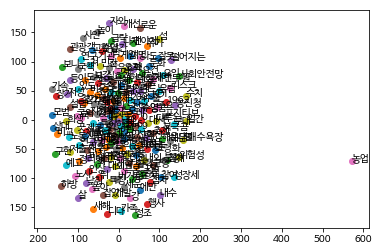

In [20]:
Make_TSNE1(2, model1, wv1, 200)

In [21]:
Make_TSNE2(2, model1, wv1, 200)

Loading BokehJS ...

  0%|          | 0/200 [00:00<?, ?it/s]C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
100%|██████████| 200/200 [00:00<00:00, 24391.16it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.004s...
[t-SNE] Computed neighbors for 200 samples in 0.056s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 0.198128
[t-SNE] KL divergence after 250 iterations with early exaggeration: 125.156868
[t-SNE] Error after 1000 iterations: 1.553657


### model1

In [ ]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=1000))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=100, batch_size=50000, verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])

score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=1000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(2, activation='sigmoid'))
model.compile(#optimizer='rmsprop',
    optimizer='adadelta',
              #loss='binary_crossentropy',
    #optimizer=SGD(lr=0.2), 
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train, epochs=100, batch_size=50000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
plot_history(history)